# Imports

In [1]:
#importing keys
from config import API_Key


#importing dataframes and data handling
import pandas as pd
import requests
import json


#importing sciencey stuff
import random
import numpy as np
import scipy


#importing display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from pprint import pprint
import IPython


#additional imports
import time
from citipy import citipy

# Function Definitions

In [2]:
#theta is latitude,  varpsi is longitude
def convert_latlon_to_cartesian(lat,lon):
    
    x = scipy.math.cos(lon * np.pi / 180) * scipy.math.cos(lat * np.pi / 180)
    
    y = scipy.math.cos(lat * np.pi / 180) * scipy.math.sin(lon * np.pi / 180)
    
    z = scipy.math.sin(lat * np.pi / 180)
    
    return (x,y,z)

In [3]:
def convert_cartesian_to_latlon(x,y,z):
    #r should be unnecessary for our purposes since x,y,z should always be living on the unit sphere and should always equal 1
    r = scipy.math.sqrt(x**2+y**2+z**2)
    
    lat = scipy.math.asin(z / r) * 180 / np.pi
    
    lon = scipy.math.atan2(y, x) * 180 / np.pi
    
    if lat > 180:
        lat -= 360
    
    return (lat,lon)

In [4]:
#This function was formerly written just to get random points on a unit sphere
#without regard to duplicate cities or bias towards island/coastal cities
#Still useful for demonstrations of superiority of this method of random selection compared to starter code

def getrandom_cartesian(amount):
    
    x = np.array([random.gauss(0,1) for i in np.arange(amount)])
    y = np.array([random.gauss(0,1) for i in np.arange(amount)])
    z = np.array([random.gauss(0,1) for i in np.arange(amount)])
    
    r = np.sqrt(x**2+y**2+z**2)
    x = x/r
    y = y/r
    z = z/r
    
    return (x,y,z)

In [5]:
def cartesian_distance(x1,y1,z1,x2,y2,z2):
    return scipy.math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

In [6]:
def getrandomvalid_cartesian(amount):
    
    #initialize empty lists to store output
    x_list = []
    y_list = []
    z_list = []
    cities_list = []
        
    for i in np.arange(amount):
        
        working = True
        while working:
            #letting X,Y,Z be standard normally distributed random variables
            #then (X,Y,Z) is equally likely to point in any direction
            #This avoids the bias towards polar regions seen in starter code
            x = random.gauss(0,1)
            y = random.gauss(0,1)
            z = random.gauss(0,1)
            r = scipy.math.sqrt(x**2+y**2+z**2)
            
            #Dividing by the norm of (X,Y,Z) makes it so the point lives on the unit sphere
            x /= r
            y /= r
            z /= r
            
            #Converting to latitude-longitude as this is the format most of the rest of the code prefers for our location
            lat,lon = convert_cartesian_to_latlon(x,y,z)
            
            #Find nearest city to our coordinates and only keep it if not already used and sufficiently close
            #This avoids much of the bias towards coastal and island cities seen in starter code
            city = citipy.nearest_city(lat,lon)
            if city not in cities_list:
                citylat,citylon = getcity_location(city)
                city_x,city_y,city_z = convert_latlon_to_cartesian(citylat,citylon)
                if cartesian_distance(x,y,z,city_x,city_y,city_z)<0.02:
                    x_list.append(city_x)
                    y_list.append(city_y)
                    z_list.append(city_z)
                    cities_list.append(city)
                    working=False
                    
    #Convert lists to arrays and return as output
    x_array = np.array(x_list)
    y_array = np.array(y_list)
    z_array = np.array(z_list)
    return (x_array,y_array,z_array,cities_list)

In [7]:
#This acts as a reverse lookup for city objects and finds their latitude longitude coordinates
#Duplicate city names are not affected

def getcity_location(city):
    
    for key in citipy.WORLD_CITIES_DICT:
        if citipy.WORLD_CITIES_DICT[key] == city:
            return (key[0],key[1])

    #Just in case if we run through the whole dictionary without finding our city somehow, return a value and error message
    #This should be impossible however as we pass a city object to the function
    #and the origin of those city objects are from citipy itself.
    print('Error! City not found!')
    return (0,0)

# Code

In [8]:
#Specify the number of requests
numberofrequests = 600

In [9]:
#Get randomly selected names and locations of a specified number of cities
xvalues,yvalues,zvalues,citylist = getrandomvalid_cartesian(numberofrequests)

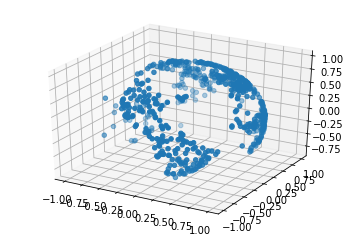

In [10]:
#To satisfy curiousity, check to see that our data is well distributed over the globe
#If getrandom_cartesian() was used instead, should be uniformly distributed with no bias to poles
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax1 = axes3d.Axes3D.scatter(ax,xvalues,yvalues,zvalues)

In [11]:
#Convert cartesian coordinates to latitude and longitude
latvalues = []
lonvalues = []
for i in np.arange(len(xvalues)):
    (latvalue,lonvalue) = convert_cartesian_to_latlon(xvalues[i],yvalues[i],zvalues[i])
    latvalues.append(latvalue)
    lonvalues.append(lonvalue)
latvalues = np.array(latvalues)
lonvalues = np.array(lonvalues)

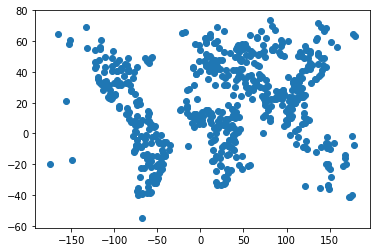

In [12]:
#To satisfy curiousity, check to see how our data is distributed over a rectangular projection of the earth
plt.scatter(lonvalues,latvalues)

In [13]:
#Extract city names and country codes from each city object and place into a dataframe
citynameslist = [citylist[i].city_name for i in np.arange(len(citylist))]
countrycodeslist = [citylist[i].country_code for i in np.arange(len(citylist))]
datadf = pd.DataFrame({'City':citynameslist,'Country':countrycodeslist})
datadf.describe()
#Keep in mind that duplicate city names are possible as several different countries have similarly named cities

,City,Country
count,600,600
unique,598,128
top,lima,ru
freq,2,65


In [14]:
#Begin requesting data from the API and keep event log

returneddata = []
waitingmessages = [r' - ', r' \ ' , r' | ', r' / ']

with open('eventlog.txt',mode='w+') as file:
    for i in np.arange(numberofrequests):
        IPython.display.clear_output(wait=True)
        print(f'Waiting: {waitingmessages[i%4]}  Processing request {i} of {numberofrequests}')
        response = requests.request('GET',f'http://api.openweathermap.org/data/2.5/weather?lat={latvalues[i]}&lon={lonvalues[i]}&appid={API_Key}&units=imperial')
        returneddata.append(response.json())
        file.write(f'[{time.clock()}] Request {i} of {numberofrequests}: Response code [{response.status_code}]: Requesting data about {citynameslist[i]} at lat:{latvalues[i]}, lon:{lonvalues[i]}\n')
        
        #With free API key there is a limit of 60 requests per minute
        #Once every 55 requests then, wait for a minute before continuing.
        if (i%55 == 0) and (i != 0) and (i != numberofrequests - 1):
            file.write(f'[{time.clock()}] Reaching request limit.  Waiting for 60 seconds...\n')
            for k in np.arange(60):
                time.sleep(1)
                #Print changing wait message to show the program did not freeze
                IPython.display.clear_output(wait=True)
                print(f'Waiting: {waitingmessages[k%4]}  Processing request {i} of {numberofrequests}\nNearing Request Limit: Paused for {60-k} more seconds')
IPython.display.clear_output(wait=True)
print(f'Task Complete.  {numberofrequests} Requests Processed.\nSee Event Log For More Details.')

Task Complete.  600 Requests Processed.
See Event Log For More Details.


# Output

In [15]:
#Parse received data into a dataframe
outputdf = pd.DataFrame({'City Name':citynameslist, 'Country Code':countrycodeslist, 'Latitude':latvalues, 'Longitude':lonvalues,
                         'Temperature (F)':[returneddata[i]['main']['temp'] for i in np.arange(numberofrequests)],
                        'Humidity':[returneddata[i]['main']['humidity'] for i in np.arange(numberofrequests)],
                        'Cloudiness':[returneddata[i]['weather'][0]['main'] for i in np.arange(numberofrequests)],
                        'Cloudiness Description':[returneddata[i]['weather'][0]['description'] for i in np.arange(numberofrequests)],
                        'Cloudiness Percentage':[returneddata[i]['clouds']['all'] for i in np.arange(numberofrequests)],
                         'Wind Speed (mph)':[returneddata[i]['wind']['speed'] for i in np.arange(numberofrequests)]})

In [16]:
outputdf.describe()

,Latitude,Longitude,Temperature (F),Humidity,Cloudiness Percentage,Wind Speed (mph)
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,19.493034,22.423302,66.542600,73.765000,37.615000,7.374633
std,27.675750,80.168218,16.514866,24.087898,35.470368,5.550481
min,-54.800000,-174.350000,13.620000,3.000000,0.000000,0.160000
25%,-1.695833,-52.816667,55.140000,58.000000,0.000000,3.180000
50%,22.225000,28.141571,69.960000,81.000000,24.000000,5.860000
75%,42.571528,87.650000,78.037500,94.000000,75.000000,9.357500
max,73.506944,179.316667,98.220000,100.000000,100.000000,39.150000


In [17]:
#Output the data collected to a CSV file
outputdf.to_csv('WeatherPy_output.csv')

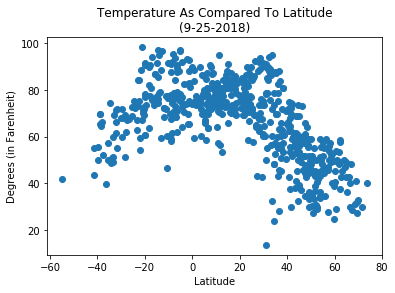

In [18]:
plt.scatter(outputdf['Latitude'],outputdf['Temperature (F)'])
plt.xlabel("Latitude")
plt.ylabel("Degrees (in Farenheit)")
plt.title(f"Temperature As Compared To Latitude\n({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]})")
plt.savefig(f'TemperatureVsLatitude({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]}).png')

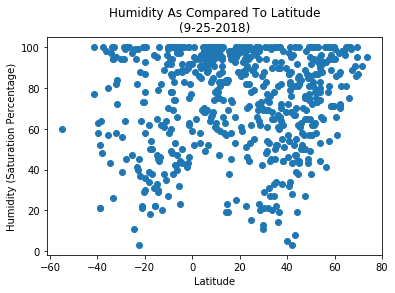

In [19]:
plt.scatter(outputdf['Latitude'],outputdf['Humidity'])
plt.xlabel('Latitude')
plt.ylabel('Humidity (Saturation Percentage)')
plt.title(f'Humidity As Compared To Latitude\n({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]})')
plt.savefig(f'HumidityVsLatitude({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]}).png')

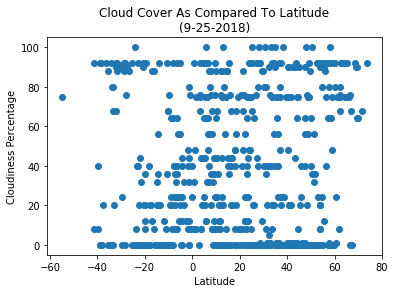

In [20]:
plt.scatter(outputdf['Latitude'],outputdf['Cloudiness Percentage'])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness Percentage")
plt.title(f"Cloud Cover As Compared To Latitude\n({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]})")
plt.savefig(f'CloudinessVsLatitude({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]}).png')

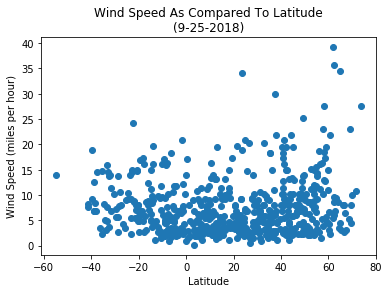

In [21]:
plt.scatter(outputdf['Latitude'],outputdf['Wind Speed (mph)'])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (miles per hour)')
plt.title(f'Wind Speed As Compared To Latitude\n({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]})')
plt.savefig(f'WindspeedVsLatitude({time.localtime()[1]}-{time.localtime()[2]}-{time.localtime()[0]}).png')